### Optimisation of positioning of the turbine
This notebook will look to optimise the positioning of the turbine to provide maximum power output allowing for variation in position (and eventually RPM, and other design parameters)

In [3]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from breastshot_calcs import breastTurbine
from river_class import river_obj
from undershot_calcs import underTurbine


In [9]:
# define a generic river object
river = river_obj(0.7, 0.3, 1.5)

# define the turbine
radius = 0.504
width = 1.008
num_blades = 5
# x_centre = 0
# y_centre = 0

turbine = breastTurbine( river)

# first define the function to be optimised
def fun(Y):
    # unpack the variables
    x, y = Y
    # define the power
    power = turbine.analysis(x , y  , RPM = 15)
    
    return -power

# define the bounds of the optimisation
bounds = [(-1,-1), (4,4)]

# define the initial guess
x0 = [1, -0.2]

# run the optimisation
res = opt.fmin(fun, x0 )
# newx, newy = res.allvecs[-1]

# print the results
newx, newy = res
print('The optimal position is: ({}, {})'.format(newx, newy))

# reinstantiate the turbine
turbine = breastTurbine( newx, newy, river)




Optimization terminated successfully.
         Current function value: -494.104133
         Iterations: 85
         Function evaluations: 163
The optimal position is: (0.8921606293676614, -0.24195239861558682)


AttributeError: 'numpy.float64' object has no attribute 'x_nappe'

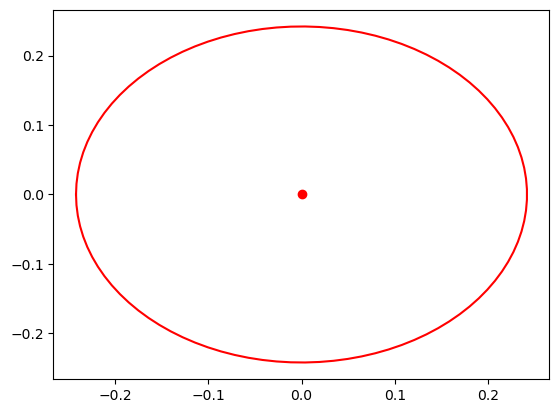

In [10]:
# plot the results - the turbine is in red
turbine.plot_turbine()



In [11]:
# show the performance of the turbine
turbine.analysis(newx, newy , RPM = 15)

# plot the power vs. theta
plt.plot(turbine.avg_power_angle, turbine.avg_power_list)

print('Breast shot turbine average power: ', turbine.avg_power, 'W')
# plot average power for line
plt.plot([turbine.avg_power_angle[0], turbine.avg_power_angle[-1]], [turbine.avg_power, turbine.avg_power], 'r--')

plt.xlabel('Blade rotational angle theta')
plt.ylabel('Output power [W]')
# plt.title('Output power vs. blade rotational angle for Breastshot turbine')



AttributeError: 'numpy.float64' object has no attribute 'x_nappe'

In [ ]:
# # find the correlation between river parameters and power
# # define the river parameters
# river_width = [0.4, 0.6 ] #, 0.8, 1.0, 1.2]
# river_depth = [0.3, 0.5]#, 0.7, 0.9, 1.1]
# river_velocity = [0.5, 1.0]#, 1.5, 2.0, 2.5]

# # define the turbine parameters
# radius = 0.504
# width = 1.008
# num_blades = 5
# x_centre = 0
# y_centre = 0

# # define the turbine
# turbine = breastTurbine(radius, width, num_blades, x_centre, y_centre, river)

# power_mat = []


# # loop through the river parameters and optimise for each
# for i in range(len(river_width)):
#     for j in range(len(river_depth)):
#         for k in range(len(river_velocity)):
#             # define the river
#             river = river_obj(river_width[i], river_depth[j], river_velocity[k])
#             # optimise the turbine
#             try:
#                 turbine = breastTurbine(radius, width, num_blades, x_centre, y_centre, river)
#                 rpm = turbine.find_RPM()
#                 power, x, y = turbine.optimise( RPM = rpm)
#                 # calculate the rpm
                
#             except:
#                 power = 0
#             # store the power
#             power_mat.append([i,j,k,power])
            





In [ ]:
# # make power_mat into a dataframe
# power_df = pd.DataFrame(power_mat, columns = ['width', 'depth', 'velocity', 'power'])

# # remove rows with zero power
# power_df = power_df[power_df['power'] != 0]

# # make correlation matrix
# corr = power_df.corr()

# # plot the correlation matrix
# plt.matshow(corr)
# plt.xticks(range(len(corr.columns)), corr.columns)
# plt.yticks(range(len(corr.columns)), corr.columns)
# plt.colorbar()
# plt.show()


In [ ]:


# # plot the power vs. river velocity
# plt.plot(river_velocity, power_df.groupby('velocity').mean()['power'])
# plt.xlabel('River velocity (m/s)')
# plt.ylabel('Average power output (kW)')
# plt.show()


In [15]:
# demonstrate the impact of varying RPM on power output

rpms = np.linspace(5, 50, 5)
power_list = []

river = river_obj(0.7, 0.3, 2)

# initialise the turbine
turbine = breastTurbine(river=river)

# optimise the turbine
power, x, y = turbine.optimise()

# loop through the rpms


for rpm in rpms:
    power, x, y = turbine.optimise( RPM = rpm)
    power_list.append(turbine.analysis(x, y, RPM = rpm))



Turbine RPM:  18.947017034749443
Optimization terminated successfully.
         Current function value: -825.983828
         Iterations: 82
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -58.912428
         Iterations: 71
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -608.510980
         Iterations: 82
         Function evaluations: 167
Optimization terminated successfully.
         Current function value: -1734.975951
         Iterations: 83
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: -3438.413147
         Iterations: 87
         Function evaluations: 177
Optimization terminated successfully.
         Current function value: -5718.822420
         Iterations: 87
         Function evaluations: 177


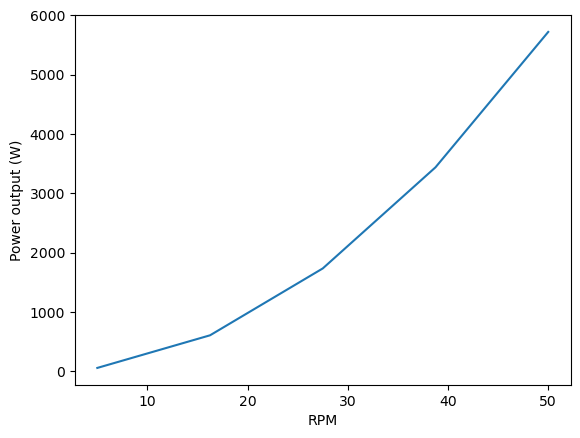

In [16]:
# plot the results
plt.plot(rpms, power_list )
plt.xlabel('RPM')
plt.ylabel('Power output (W)')
plt.show()


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -3448.2700788823136
        x: [-1.000e-01]
      nit: 0
      jac: [ 0.000e+00]
     nfev: 2
     njev: 1
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


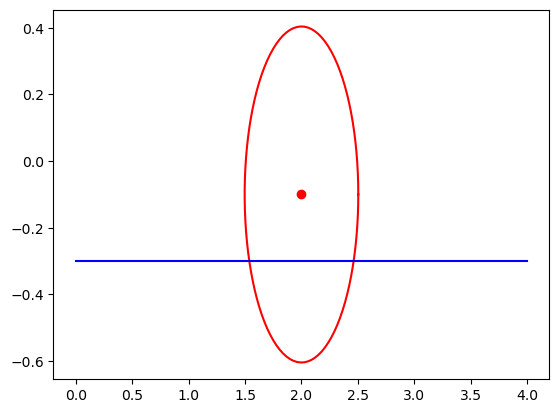

In [ ]:
# define a generic river object
river = river_obj(0.7, 0.3, 3)

# define the turbine
radius = 0.504
width = 1.008
num_blades = 5
# x_centre = 0
# y_centre = 0

under_turbine = underTurbine(radius,width, num_blades, 0.3, river)

# first define the function to be optimised
def fun(y):
    # define the power
    power = under_turbine.analysis(y , RPM = 15)
    
    return -power

# max depth
max_depth = -river.depth + radius

# run the optimisation
res = opt.minimize(fun, -0.1, bounds = [(-1, 3)])

print(res)

# newx, newy = res.allvecs[-1]

# reinstantiate the turbine
under_turbine = underTurbine(radius, width, num_blades, res.x, river)

# plot the results - the turbine is in red
plt.plot(under_turbine.x_centre, under_turbine.y_centre, 'ro')
plt.plot(under_turbine.x, under_turbine.y, 'r')

# plot the river as line at -river.depth
plt.plot([-0,4], [-river.depth, -river.depth], 'b')




